In [74]:
import pandas as pd
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Any, Tuple
import gzip
import pickle

In [2]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/calibration_set_featurized_response_BE.parquet.gzip"
)

test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_featurized_response_BE.parquet.gzip"
)

In [75]:
def plot_calibration_curves(clf_list, X_test, y_test):
    num_classifiers = len(clf_list)

    # Create a larger grid for the histograms
    fig = plt.figure(figsize=(10, num_classifiers * 5))
    gs = GridSpec(num_classifiers + 2, 2)
    colors = plt.get_cmap('Dark2')

    ax_calibration_curve = fig.add_subplot(gs[:2, :])
    calibration_displays = {}
    markers = ["^", "v", "s", "o", "D", "*", "P", "X", "d", "|", "_"]

    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i]
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")

    # Add histogram
    for i, (_, name) in enumerate(clf_list):
        ax = fig.add_subplot(gs[2 + i // 2, i % 2])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()

In [53]:
def calibrate_and_save_classifiers(classifier_list, X_cal, y_cal):
    """
    Calibrate classifiers and save them to a list.

    :param classifier_list: List of (classifier, name) tuples
    :param X_cal: Calibration set features
    :param y_cal: Calibration set labels
    :return: List of calibrated classifiers
    """
    calibrated_classifiers = []

    for clf, name in classifier_list:
        print(clf, name)
        # Calibrate the classifier
        calibrated_clf = CalibratedClassifierCV(estimator=clf, method='isotonic', cv='prefit', n_jobs=-1)
        calibrated_clf.fit(X_cal, y_cal)

        # Save the calibrated classifier to the list
        calibrated_classifiers.append((calibrated_clf, name))

    return calibrated_classifiers

In [22]:
filename = f"LightGBM_BE.sav.gz"
filename1 = f"Random_Forest_BE.sav.gz"
filename2 = f"Logistic_Regression_BE.sav.gz"
filename3 = f"Hist_GB_BE.sav.gz"
filename4 = f"Ada_Boost_BE.sav.gz"
filename5 = f"Decision_Tree_BE.sav.gz"
filename6 = f"Extra_Trees_Classifier_BE.sav.gz"
filename7 = f"XGBoost_BE.sav.gz"
filename8 = f"Gradient_Boosting_BE.sav.gz"
filename9 = f"Gaussian_NB_BE.sav.gz"
# filename10 = f"Bernoulli_NB_BE.sav.gz"

In [24]:
with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename}", "rb") as f:
    lgbm = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename1}", "rb") as f:
    rfc = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename2}", "rb") as f:
    lr = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename3}", "rb") as f:
    hgb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename4}", "rb") as f:
    ada = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename5}", "rb") as f:
    dt = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename6}", "rb") as f:
    et = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename7}", "rb") as f:
    xgb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename8}", "rb") as f:
    gb = pickle.load(f)

with gzip.GzipFile(f"../models/chrome/08_12_2022/response/{filename9}", "rb") as f:
    gnb = pickle.load(f)

# with gzip.GzipFile(f"../models/chrome/08_12_2022/{filename10}", "rb") as f:
#     nb = pickle.load(f)

In [27]:
clf_list = [
    (lr, "Logistic"),
    (hgb, "HGB"),
    (lgbm, "LGBM"),
    (rfc, "Random forest"),
    (ada, "Ada Boost"),
    (dt, "Decision tree"),
    (et, "Extra Trees Classifier"),
    (xgb, "XGBoost"),
    (gb, "Gradient boosting"),
    (gnb, "Gaussian NB"),
    # (nb, "Naive Bayes"),
]

In [56]:
for clf, name in clf_list:
    print(f"{name}: {hasattr(clf, 'classes_')}")

Logistic: True
HGB: True
LGBM: True
Random forest: True
Ada Boost: True
Decision tree: True
Extra Trees Classifier: True
XGBoost: True
Gradient boosting: True
Gaussian NB: True


In [29]:
X_train, y_train = train_data.iloc[:, 2:-2], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, 2:-2], test_data[["tracker"]]

In [57]:
%%time
calibrated_clf_list = calibrate_and_save_classifiers(clf_list, X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=10,
                   solver='newton-cholesky') Logistic
HistGradientBoostingClassifier(random_state=10) HGB
LGBMClassifier(n_jobs=-1, random_state=10) LGBM
RandomForestClassifier(max_features=None, n_jobs=-1, random_state=10) Random forest
AdaBoostClassifier(random_state=10) Ada Boost
DecisionTreeClassifier(random_state=10) Decision tree
ExtraTreesClassifier(n_jobs=-1, random_state=10) Extra Trees Classifier
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_

/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take preceden

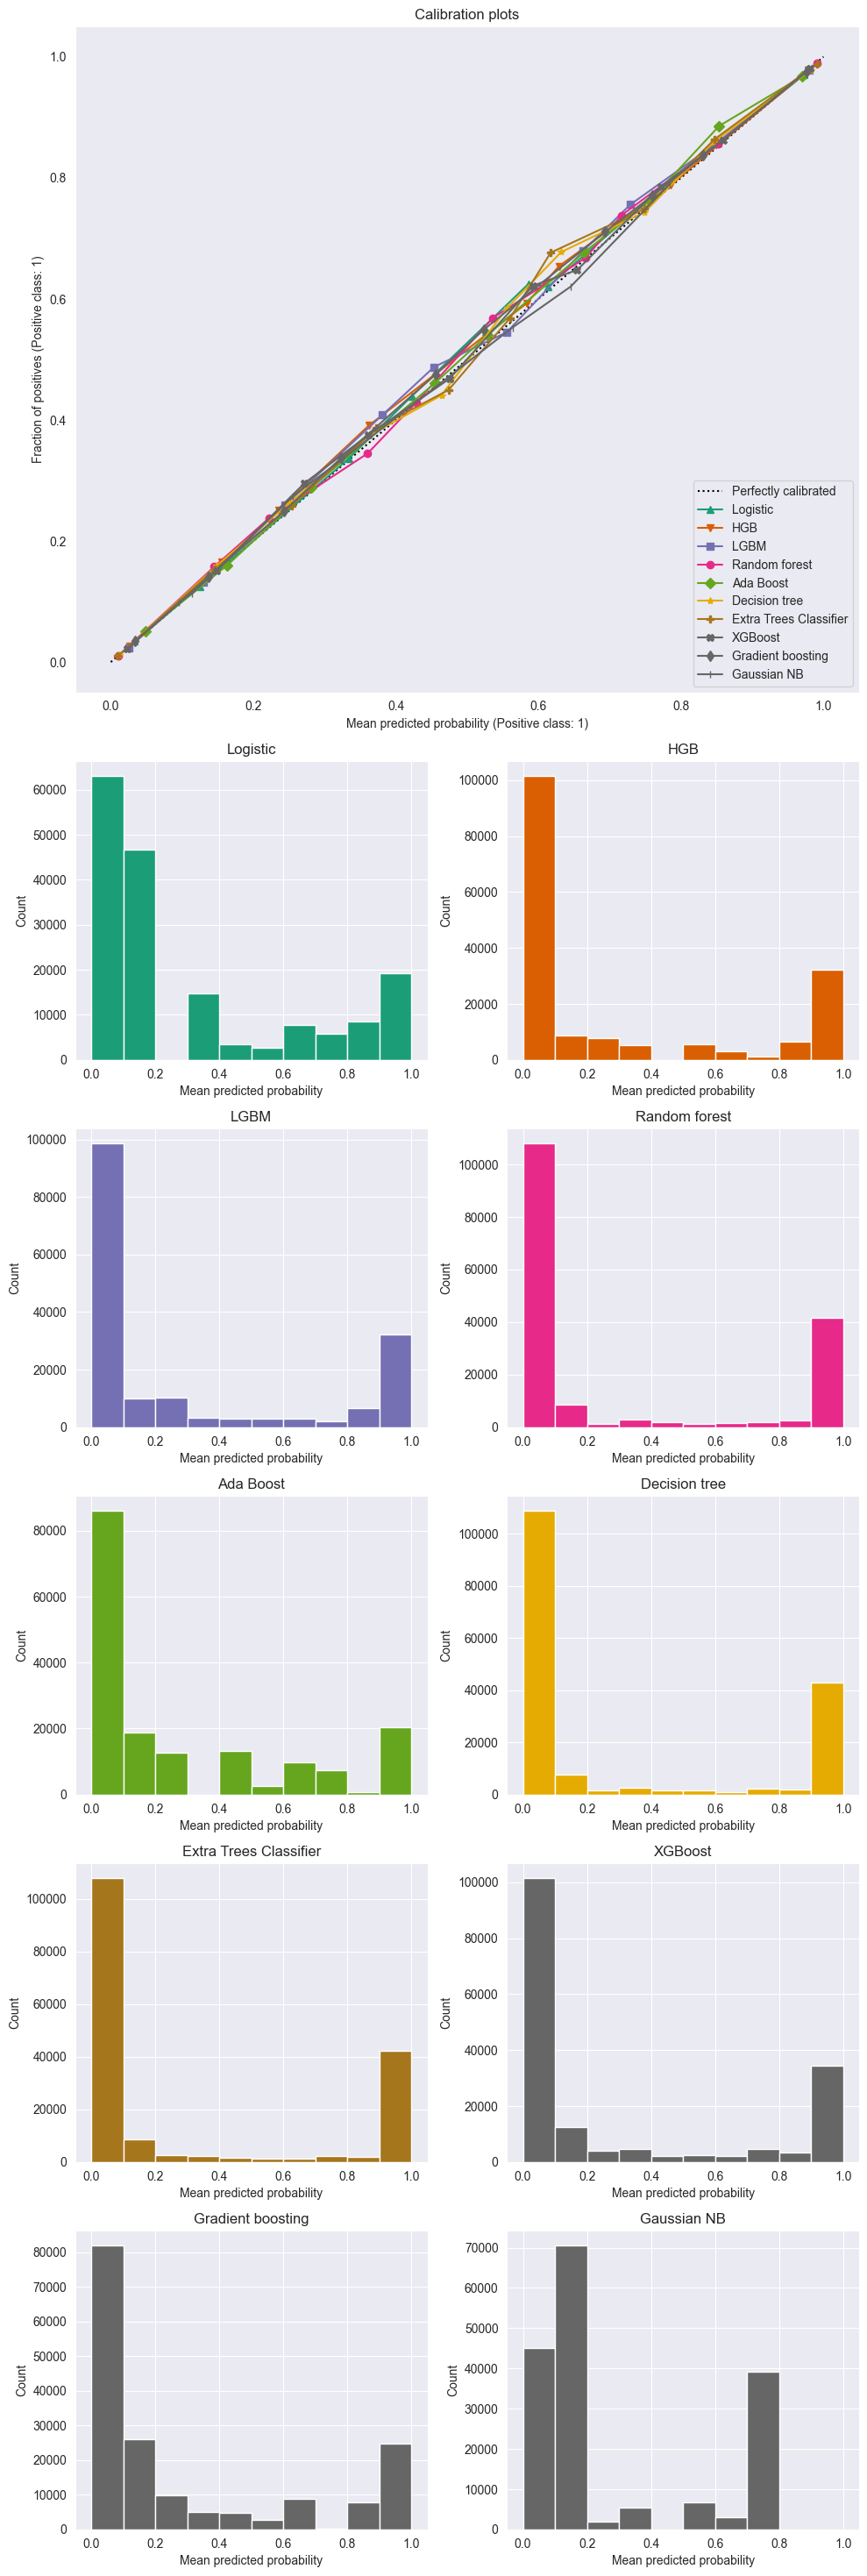

In [76]:
plot_calibration_curves(calibrated_clf_list, X_test, y_test)